# Stochastic Disturbance in ANDES

This notebook demonstrates how to implement stochastic disturbances in ANDES using the perturbation file. The disturbances occur at every time step, allowing you to interact with the simulated system just as you would in a standard ANDES simulation.

In [1]:
import andes

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
!andes misc --version

Python  3.12.0
andes   1.9.3
numpy   2.0.2
kvxopt  1.3.2.1
sympy   1.13.3
scipy   1.13.1
pandas  2.2.2
numba   0.60.0


In [4]:
andes.config_logger(stream_level=20)

Load the case, but don’t set it up yet as we need to add some devices.

In [5]:
ss = andes.load(andes.get_case('ieee14/ieee14_full.xlsx'),
                setup=True,
                no_output=True,
                default_config=True,
                pert='./pert.py')

Working directory: "/Users/jinningwang/work/demo/demo/andes_stochastic"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Parsing input file "/Users/jinningwang/work/miniconda3/envs/amsre/lib/python3.12/site-packages/andes/cases/ieee14/ieee14_full.xlsx"...
Input file parsed in 0.2449 seconds.
System internal structure set up in 0.0140 seconds.


There are some settings that require attention.

In [6]:
# use constant power model for PQ, we need to change the power by setting PQ.Ppf
# and it is only effective in constant power mode

ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0

# turn off under-voltage PQ-to-Z conversion
ss.PQ.pq2z = 0

Solve the power flow.

In [7]:
ss.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0029 seconds.
0: |F(x)| = 0.5605182134
1: |F(x)| = 0.006202200332
2: |F(x)| = 5.819382825e-06
3: |F(x)| = 6.964193111e-12
Converged in 4 iterations in 0.0025 seconds.


True

Init the TDS.

In [8]:
_ = ss.TDS.init()

Perturbation file "./pert.py" loaded.
Initialization for dynamics completed in 0.0377 seconds.
Initialization was successful.


Then, we can run the simulation with pertubation.

- More details about Pertubation file can be found at https://docs.andes.app/en/latest/getting_started/formats/disturbance.html#perturbation-file
- Do a load change in ANDES: https://docs.andes.app/en/latest/_examples/ex9.html

In [9]:
ss.TDS.config.tf = 50

ss.TDS.config.criteria = 0  # turn off the criteria check for testing purpose
ss.TDS.config.no_tqdm = True  # you can turn the progess bar on if necessary

ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-50 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Simulation to t=50.00 sec completed in 1.6348 seconds.


True

In the pert file, we can define a random load change and it will happen at ***EVERY*** time step.
Check the source file ``pert.py`` for the details of the perturbation.

(<Figure size 700x1000 with 2 Axes>,
 <Axes: xlabel='Time [s]', ylabel='Bus Volt. [p.u.]'>)

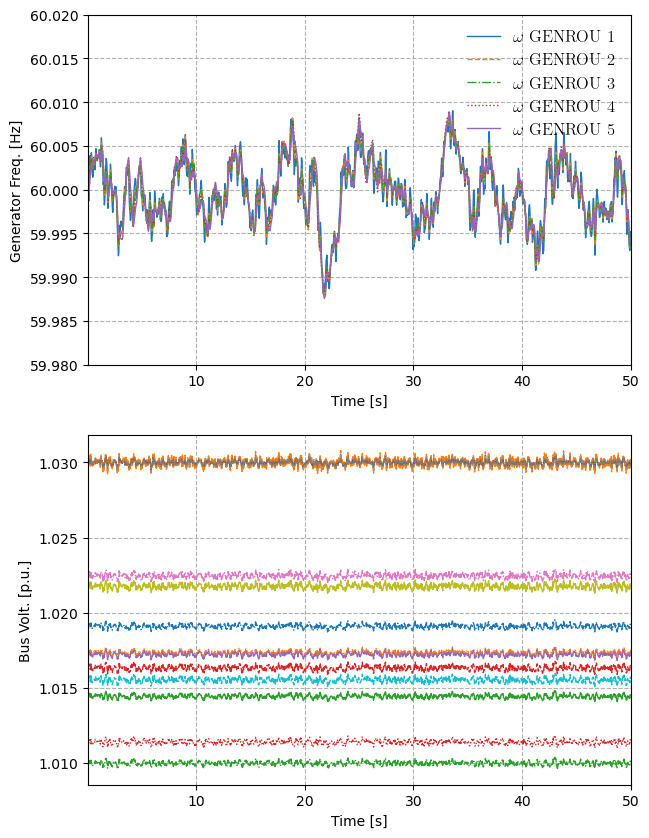

In [13]:
plt.style.use('default')
fig, ax = plt.subplots(2, 1, figsize=(7, 10))
plt.subplots_adjust(hspace=0.2)

ss.TDS.plt.plot(ss.GENROU.omega,
                ytimes=ss.config.freq,
                ymin=59.98, ymax=60.02,
                grid=True, show=False,
                ylabel='Generator Freq. [Hz]',
                fig=fig, ax=ax[0])
ss.TDS.plt.plot(ss.Bus.v,
                ylabel='Bus Volt. [p.u.]',
                grid=True, show=False,
                fig=fig, ax=ax[1])